In [0]:
import torch
from torchvision import transforms, datasets

# Get data

In [0]:
# create a transform to normalize data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [0]:
# Download train dataset
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, transform=transform, train=True)
# load data
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)

# Download test dataset
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
# load data
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

0it [00:00, ?it/s]

26427392it [00:02, 9876945.61it/s]                               


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 72851.16it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 3131344.47it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21292.22it/s]            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Create a Network

In [0]:
from torch import nn, optim
import torch.nn.functional as F

Using logits at the output rather than softmax probabilities. This avoids the problem of Floating-point operation [read here](https://docs.python.org/3/tutorial/floatingpoint.html). Softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one. So we use log-probabilities

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    # create the network's structure
    self.input = nn.Linear(784, 256)
    self.hidden1 = nn.Linear(256, 128)
    self.hidden2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)
    
  # Forward Pass  
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.input(x))
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    x = F.log_softmax(self.output(x), dim=1)
    
    return x

# Train

In [0]:
model = Classifier()
model

Classifier(
  (input): Linear(in_features=784, out_features=256, bias=True)
  (hidden1): Linear(in_features=256, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
# criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
# train the network
epochs = 5
train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # log probabilities
    log_ps = model(images)
    
    # loss 
    loss = criterion(log_ps, labels)
    
    # backprop
    # reset gradients
    optimizer.zero_grad()
    
    # gradient calculation
    loss.backward()
    
    # update weights
    optimizer.step()
    
    # update loss
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
      
    with torch.no_grad():
      
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
      
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5..  Training Loss: 0.356..  Test Loss: 0.377..  Test Accuracy: 0.864
Epoch: 2/5..  Training Loss: 0.334..  Test Loss: 0.414..  Test Accuracy: 0.849
Epoch: 3/5..  Training Loss: 0.316..  Test Loss: 0.372..  Test Accuracy: 0.870
Epoch: 4/5..  Training Loss: 0.305..  Test Loss: 0.362..  Test Accuracy: 0.875
Epoch: 5/5..  Training Loss: 0.290..  Test Loss: 0.367..  Test Accuracy: 0.868


# Test

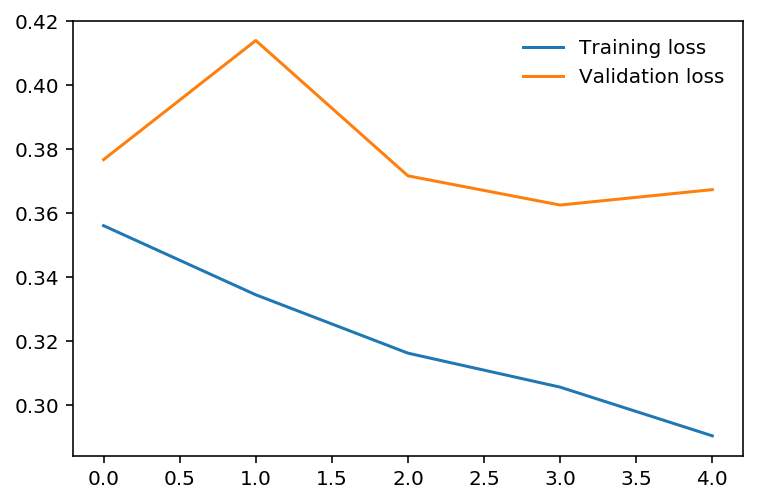

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
# grab data
dataiter = iter(testloader)
images, labels = dataiter.next()

# select an image
img = images[1]
label = labels[1]

# predict
output_ps = torch.exp(model(img))

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
  with torch.no_grad():
    image = img.resize_(1, 28, 28).numpy().squeeze()
    ps = ps.data.numpy().squeeze()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.imshow(image)

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                              'Trouser',
                              'Pullover',
                              'Dress',
                              'Coat',
                              'Sandal',
                              'Shirt',
                              'Sneaker',
                              'Bag',
                              'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.show()

In [0]:
view_classify(img, output_ps)